In [504]:
import pandas as pd
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import statsmodels.api as sm
import numpy as np
from sklearn.model_selection import GridSearchCV
import pickle
import shap
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from xgboost import plot_importance
import matplotlib.pyplot as plt

## 切分男女資料

In [505]:
df = pd.read_csv("./dataset/student_scores_clean.csv")

# df = df[df["gender"] == 1]
# print("Male students data shape:", df.shape)
# sex = "male"

df = df[df["gender"] == 0]
print("Female students data shape:", df.shape)
sex = "female"

y = df

Female students data shape: (1002, 30)


In [506]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1002 entries, 1 to 1999
Data columns (total 30 columns):
 #   Column                        Non-Null Count  Dtype
---  ------                        --------------  -----
 0   id                            1002 non-null   int64
 1   gender                        1002 non-null   int64
 2   part_time_job                 1002 non-null   int64
 3   absence_days                  1002 non-null   int64
 4   extracurricular_activities    1002 non-null   int64
 5   weekly_self_study_hours       1002 non-null   int64
 6   math_score                    1002 non-null   int64
 7   history_score                 1002 non-null   int64
 8   physics_score                 1002 non-null   int64
 9   chemistry_score               1002 non-null   int64
 10  biology_score                 1002 non-null   int64
 11  english_score                 1002 non-null   int64
 12  geography_score               1002 non-null   int64
 13  career_Accountant             1002 non

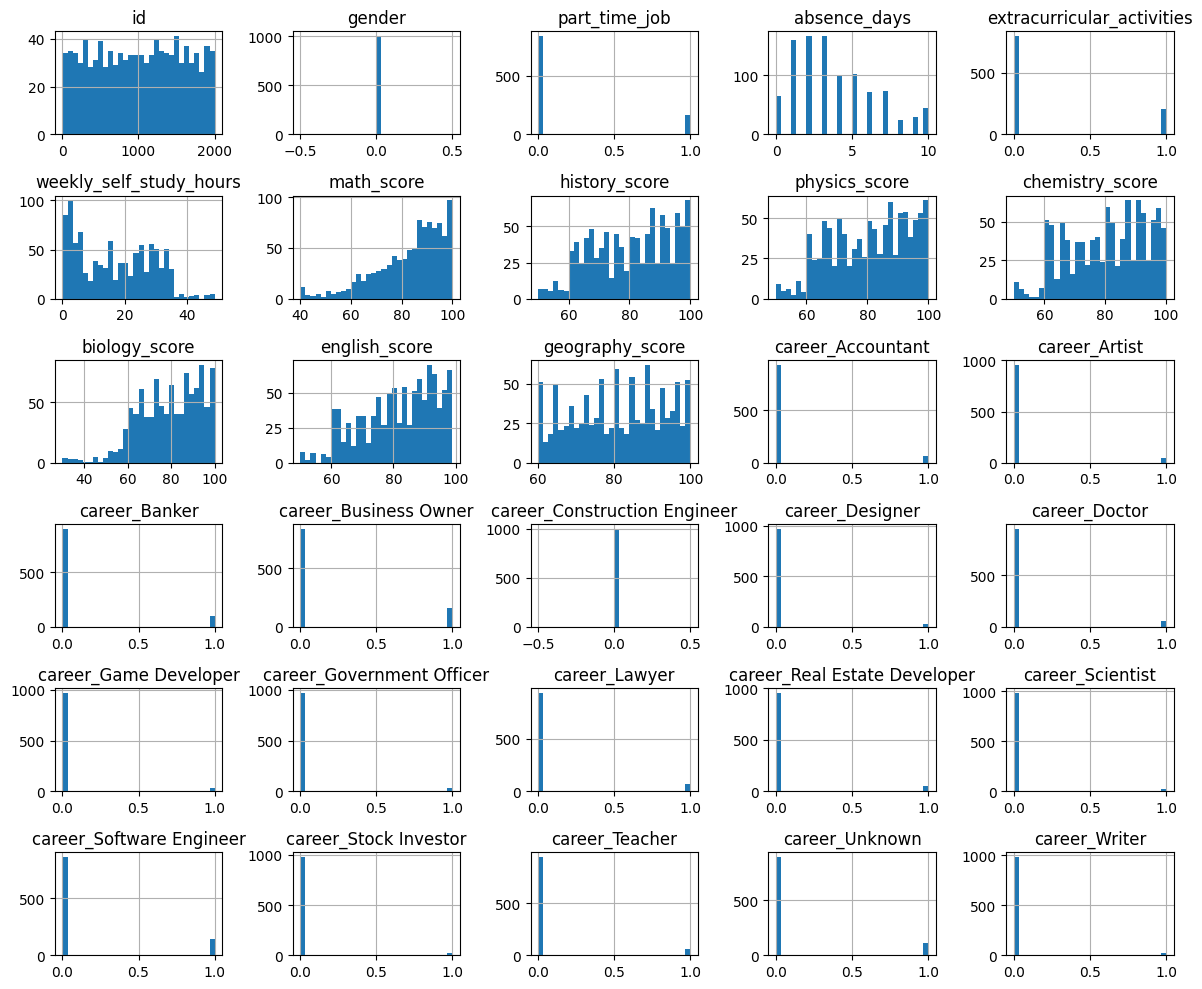

In [507]:
df.hist(bins=30, figsize=(12, 10))
plt.tight_layout()
plt.show()


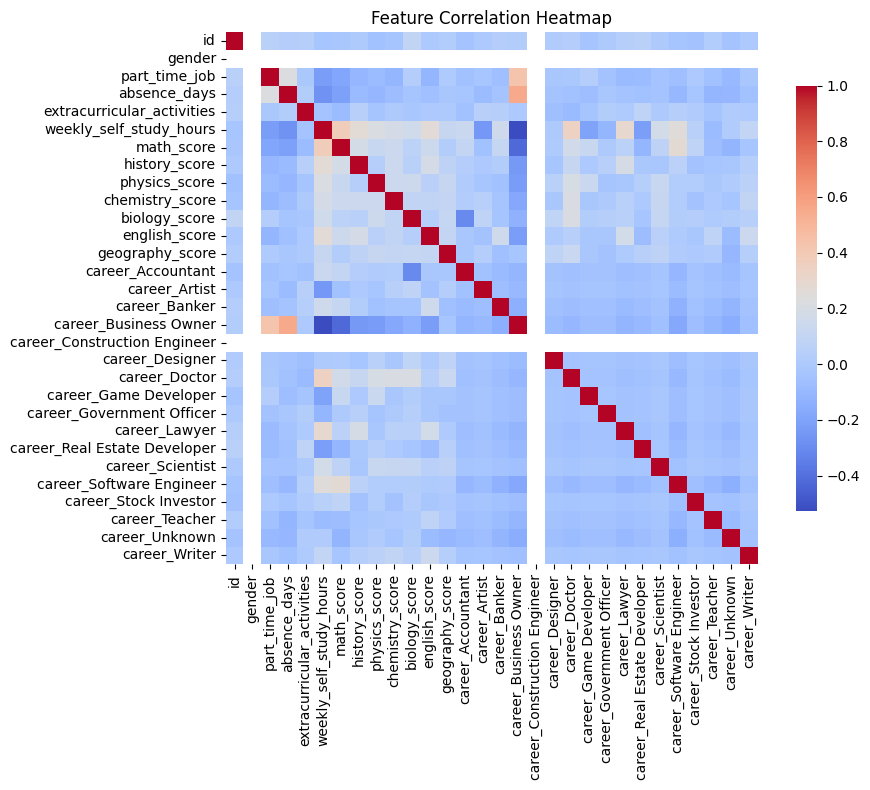

In [508]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 計算特徵間的皮爾森相關係數
corr = df.corr()

# 繪製熱圖
plt.figure(figsize=(10, 8))
sns.heatmap(corr, fmt=".2f", cmap="coolwarm", square=True, cbar_kws={"shrink": 0.8})
plt.title("Feature Correlation Heatmap")
plt.tight_layout()
plt.show()


In [509]:
career_columns = [col for col in df.columns if col.startswith("career_")]

features = [
    "part_time_job",
    "absence_days",
    "extracurricular_activities",
    "weekly_self_study_hours"
] + career_columns

if (sex == "male"): features.remove("career_Teacher") # male students do not have this career
if (sex == "female"): features.remove("career_Construction Engineer") # female students do not have this career

print("Features num:", len(features))

Features num: 20


## 切分科目

In [510]:
X = df[features]

subject = "math"  # Change this to the subject you want to predict
# math
# history
# physics
# chemistry
# biology
# english
# geography

y = df[subject+ "_score"]


## 設定模型

In [511]:
model_select = "xgb"  # Change this to the model you want to use
# xgb
# lr
# rfr

In [512]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [513]:
if model_select == "xgb":
    param_grid = {
        'n_estimators': [100, 300],
        'max_depth': [2, 4, 6],
        'learning_rate': [0.01, 0.1],
        'subsample': [0.8, 1],
        'colsample_bytree': [0.8, 1],
        'reg_alpha': [0, 0.1],
        'reg_lambda': [0.1, 1]
    }

    xgb_model = XGBRegressor(objective='reg:squarederror', random_state=42)

    grid_search = GridSearchCV(
        estimator=xgb_model,
        param_grid=param_grid,
        scoring='neg_root_mean_squared_error',
        cv=5,
        n_jobs=-1,
        verbose=1
    )

    grid_search.fit(X_train, y_train)

    print("最佳參數組合 (Best parameters):")
    print(grid_search.best_params_)

    print("最佳模型的負 RMSE (Best negative RMSE):")
    print(grid_search.best_score_)

    best_model = grid_search.best_estimator_

if model_select == "lr":
    lr_model = LinearRegression()
    lr_model.fit(X_train, y_train)
    best_model = lr_model
    
if model_select == "rfr":
    rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
    rf_model.fit(X_train, y_train)
    best_model = rf_model

with open(f'{sex}_result/model/{model_select}_{subject}_model.pkl', 'wb') as f:
    pickle.dump(best_model, f)

Fitting 5 folds for each of 192 candidates, totalling 960 fits
最佳參數組合 (Best parameters):
{'colsample_bytree': 0.8, 'learning_rate': 0.01, 'max_depth': 4, 'n_estimators': 300, 'reg_alpha': 0, 'reg_lambda': 0.1, 'subsample': 0.8}
最佳模型的負 RMSE (Best negative RMSE):
-11.016092911895024


                         Feature  Importance
7          career_Business Owner    0.315727
15      career_Software Engineer    0.085052
10         career_Game Developer    0.076722
13  career_Real Estate Developer    0.060112
18                career_Unknown    0.059395
17                career_Teacher    0.052172
9                  career_Doctor    0.044599
3        weekly_self_study_hours    0.036921
6                  career_Banker    0.035424
19                 career_Writer    0.035301
11     career_Government Officer    0.033028
5                  career_Artist    0.030158
16         career_Stock Investor    0.025802
1                   absence_days    0.020550
4              career_Accountant    0.018516
2     extracurricular_activities    0.016225
8                career_Designer    0.016044
0                  part_time_job    0.014186
12                 career_Lawyer    0.012355
14              career_Scientist    0.011711


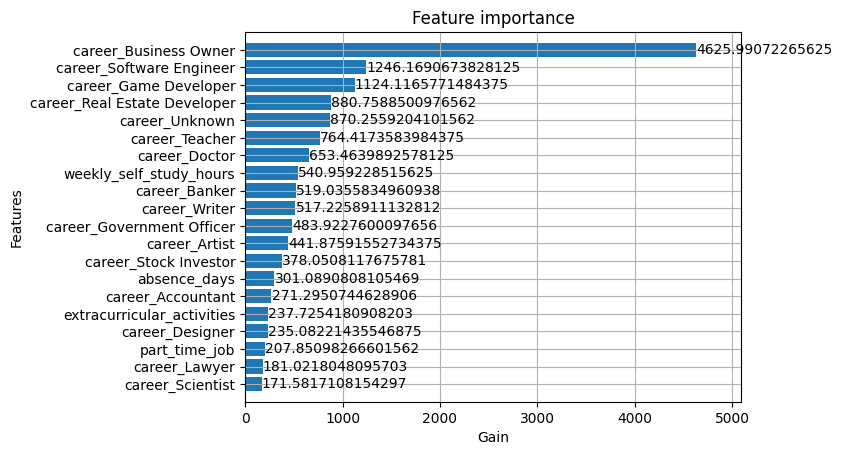

In [514]:
if model_select == "xgb":    
    importance_df = pd.DataFrame({
            'Feature': X_train.columns,
            'Importance': best_model.feature_importances_
        }).sort_values(by='Importance', ascending=False)

    print(importance_df.head(21))

    plot_importance(best_model, importance_type='gain', 
                    max_num_features=21, 
                    xlabel='Gain',
                    height=0.8)
    plt.savefig(f"{sex}_result/feature_importance/{model_select}_{subject}.png", dpi=300, bbox_inches='tight')
    plt.show()

In [515]:
y_pred = best_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mse)

print(f"MSE: {mse:.2f}") # 0~正無限大(越小越好)
print(f"MAE: {mae:.2f}") # 0~正無限大(越小越好)
print(f"R² 分數: {r2:.4f}") # 負無限大~1 (接近1越好)
print(f"RMSE: {rmse:.2f}") # 0~正無限大(越小越好)

MSE: 137.74
MAE: 9.27
R² 分數: 0.3145
RMSE: 11.74


In [516]:
mean_score = y_test.mean()
error_pct = rmse / mean_score * 100
print(f"相對誤差: {error_pct:.2f}%")

相對誤差: 14.24%


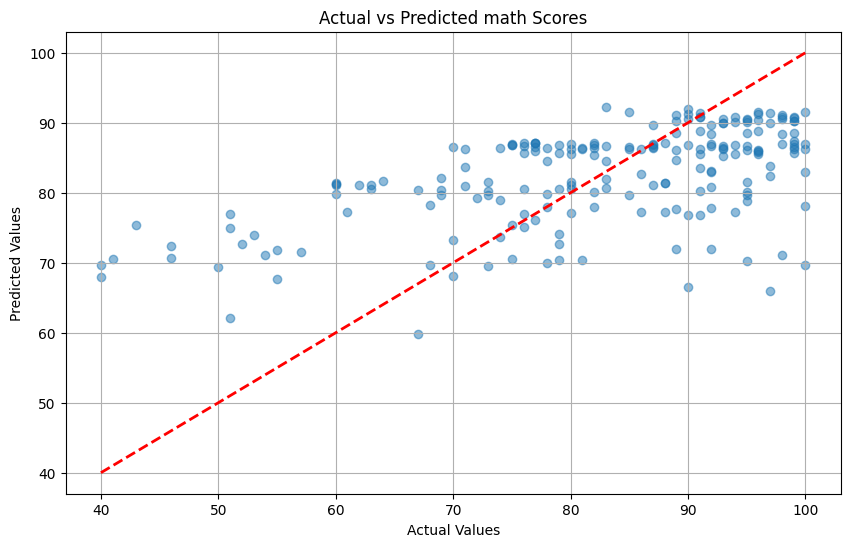

In [517]:
# 繪製實際值與預測值的散點圖
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.title(f'Actual vs Predicted {subject} Scores')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.grid()
plt.savefig(f"{sex}_result/actual_vs_predict/{model_select}_{subject}_scores.png", dpi=300, bbox_inches='tight')
plt.show()